# Sortino

Usage in C2Score:

		    + posOrZero(%[Sortino Ratio]% * 10)

In [1]:
source("JupyterUtils.R")
source("C2ScoreHypothesisPresentation.R")

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        3814      144746    -15.8700     -0.4700      0.8700      1.8349      2.1300   1082.2400     15.8069 


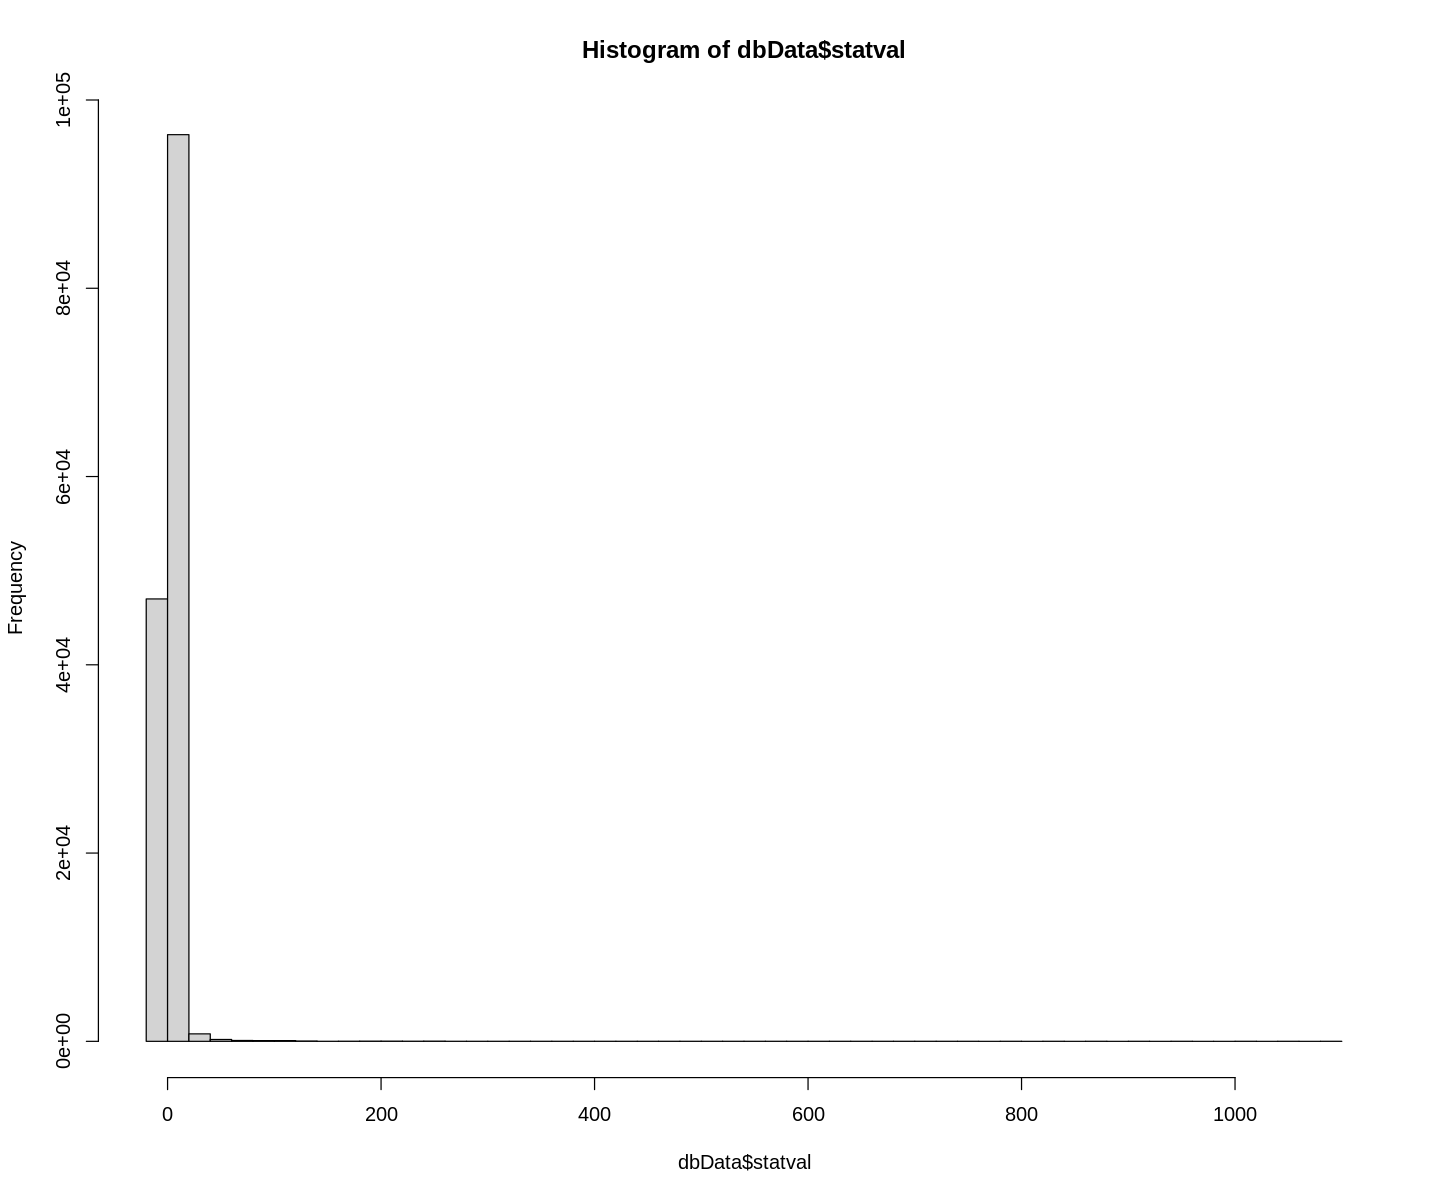

In [2]:
# What data we have.
# Let's use Age > 90
sql = "select systemid, YYYYMMDD, statval
            from historical_stats_modern h
            join c2systems sys on sys.guid=h.systemid 
            where statname='jSortino' 
                  and (DATEDIFF(cast(date_format(YYYYMMDD,'%Y%m%d') AS Date), Date(from_unixtime(added))) + 1) > 90"

dbData = getC2ScoreDbData(sql)
overview(dbData)
hist(dbData$statval,breaks=50)

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        2323       86689      0.0100      0.7600      1.4200      1.6616      2.3300      5.0000      1.1701 


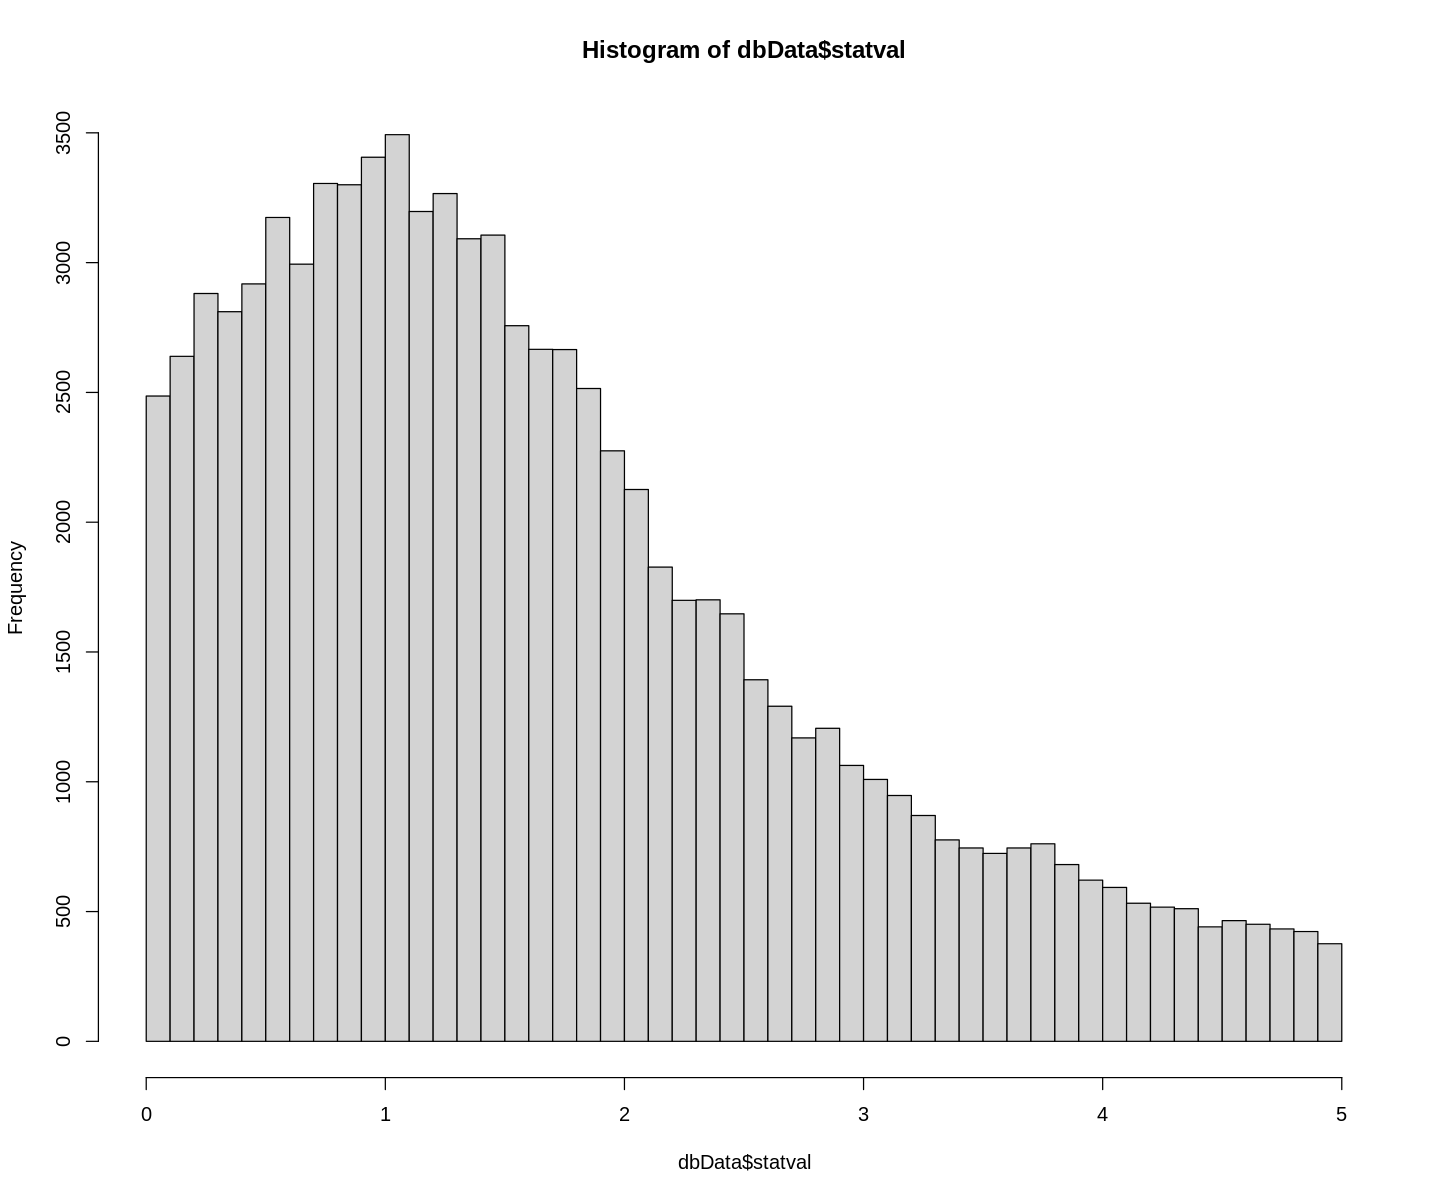

In [3]:
# We want just positive values. Reasonable upper limit should be about 5.

sql = "select systemid, YYYYMMDD, statval
            from historical_stats_modern h
            join c2systems sys on sys.guid=h.systemid 
            where statname='jSortino' 
                  and (DATEDIFF(cast(date_format(YYYYMMDD,'%Y%m%d') AS Date), Date(from_unixtime(added))) + 1) > 90
                  and statval > 0 and statval <= 5"

dbData = getC2ScoreDbData(sql)
overview(dbData)
hist(dbData$statval,breaks=50)

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        1237       35164      0.0100      0.8600      1.5500      1.7796      2.5000      5.0000      1.1949 


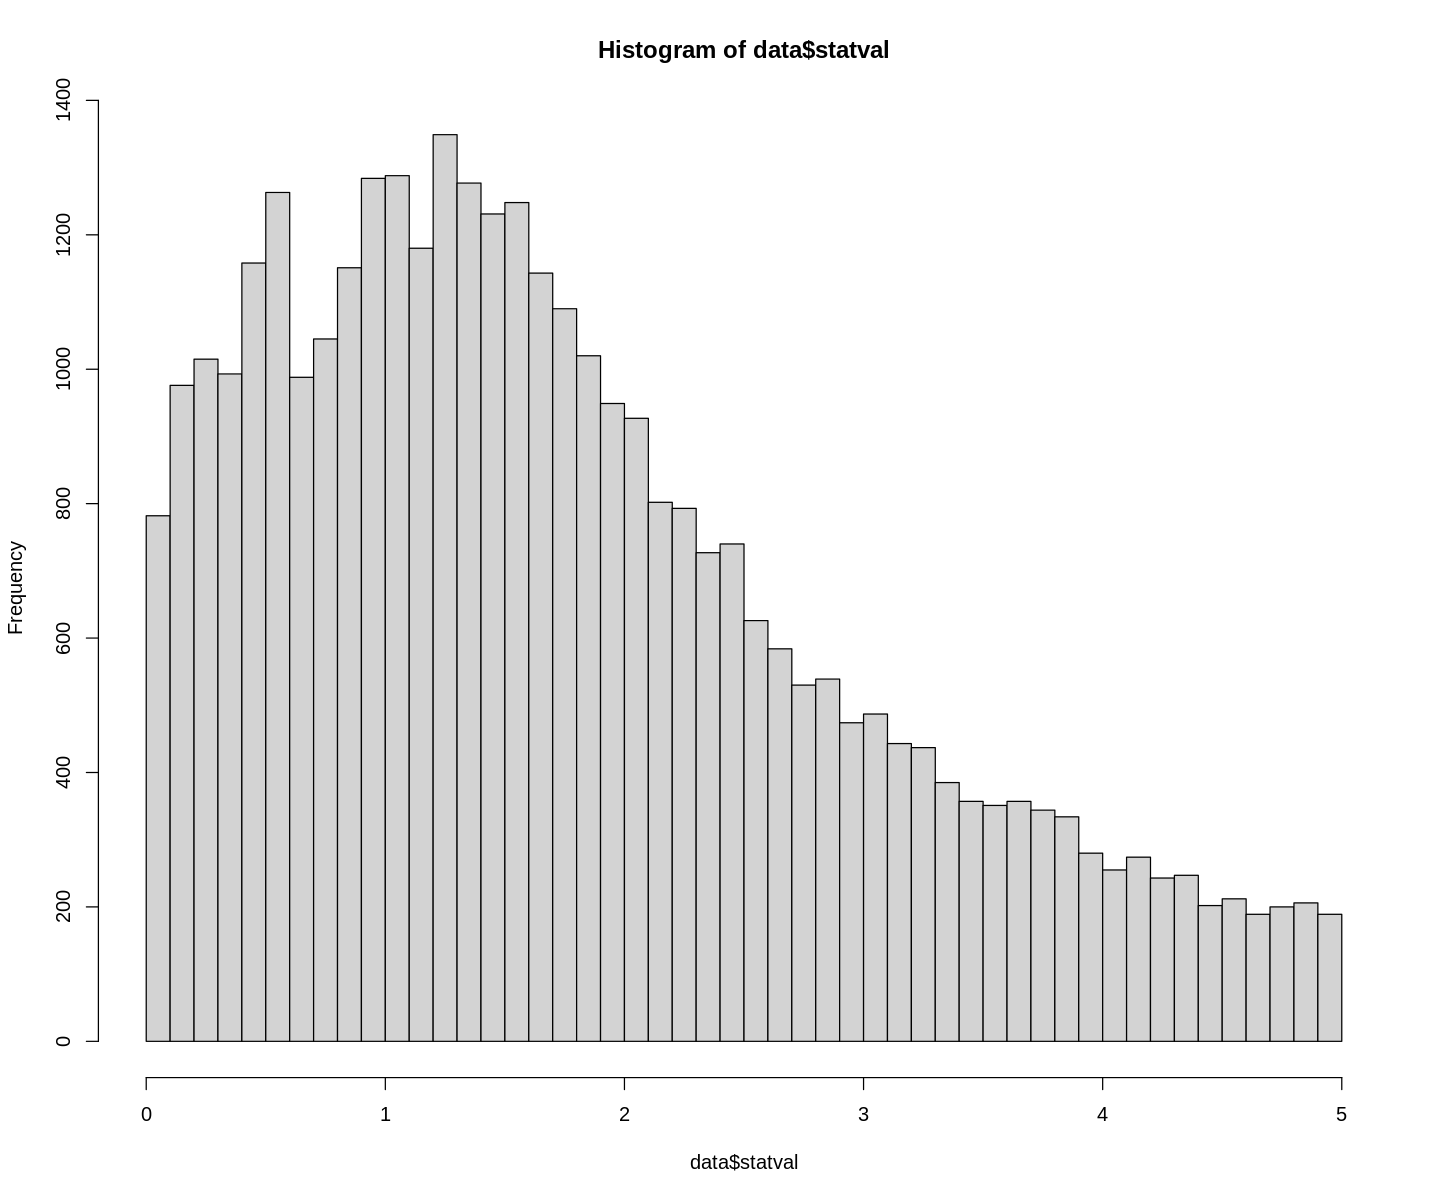

In [4]:
# Join with our cleaned data

sql = "select statval, eq.*
 from ReturnsDataInIntervalsCleanedSkip090 eq
 join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
 where 
    statname='jSortino' 
    and statval > 0 
    and statval <= 5 
    and Age > 90"

data = getC2ScoreDbData(sql)
overview(data)
hist(data$statval,breaks=50)



We have calculated and stored the whole population statistics of strategies daily returns after 7, 14, ..., 360 days. Day after day. Now, we selected a particular statistics data (a sample) from the whole population. Collective2 data are joined with a cleaned strategies set used for the population calculations. We want to know, if the average of returns of the sample is significantly higher than an average of returns of the whole population. A significance level is  0.05 .

The following table contains this hypothesis tests for defined stats intervals and all 7, 14, ..., 360 days time intervals.


Descriptive stats of all data selected in the experiment:
     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        1237       35164      0.0100      0.8600      1.5500      1.7796      2.5000      5.0000      1.1949 



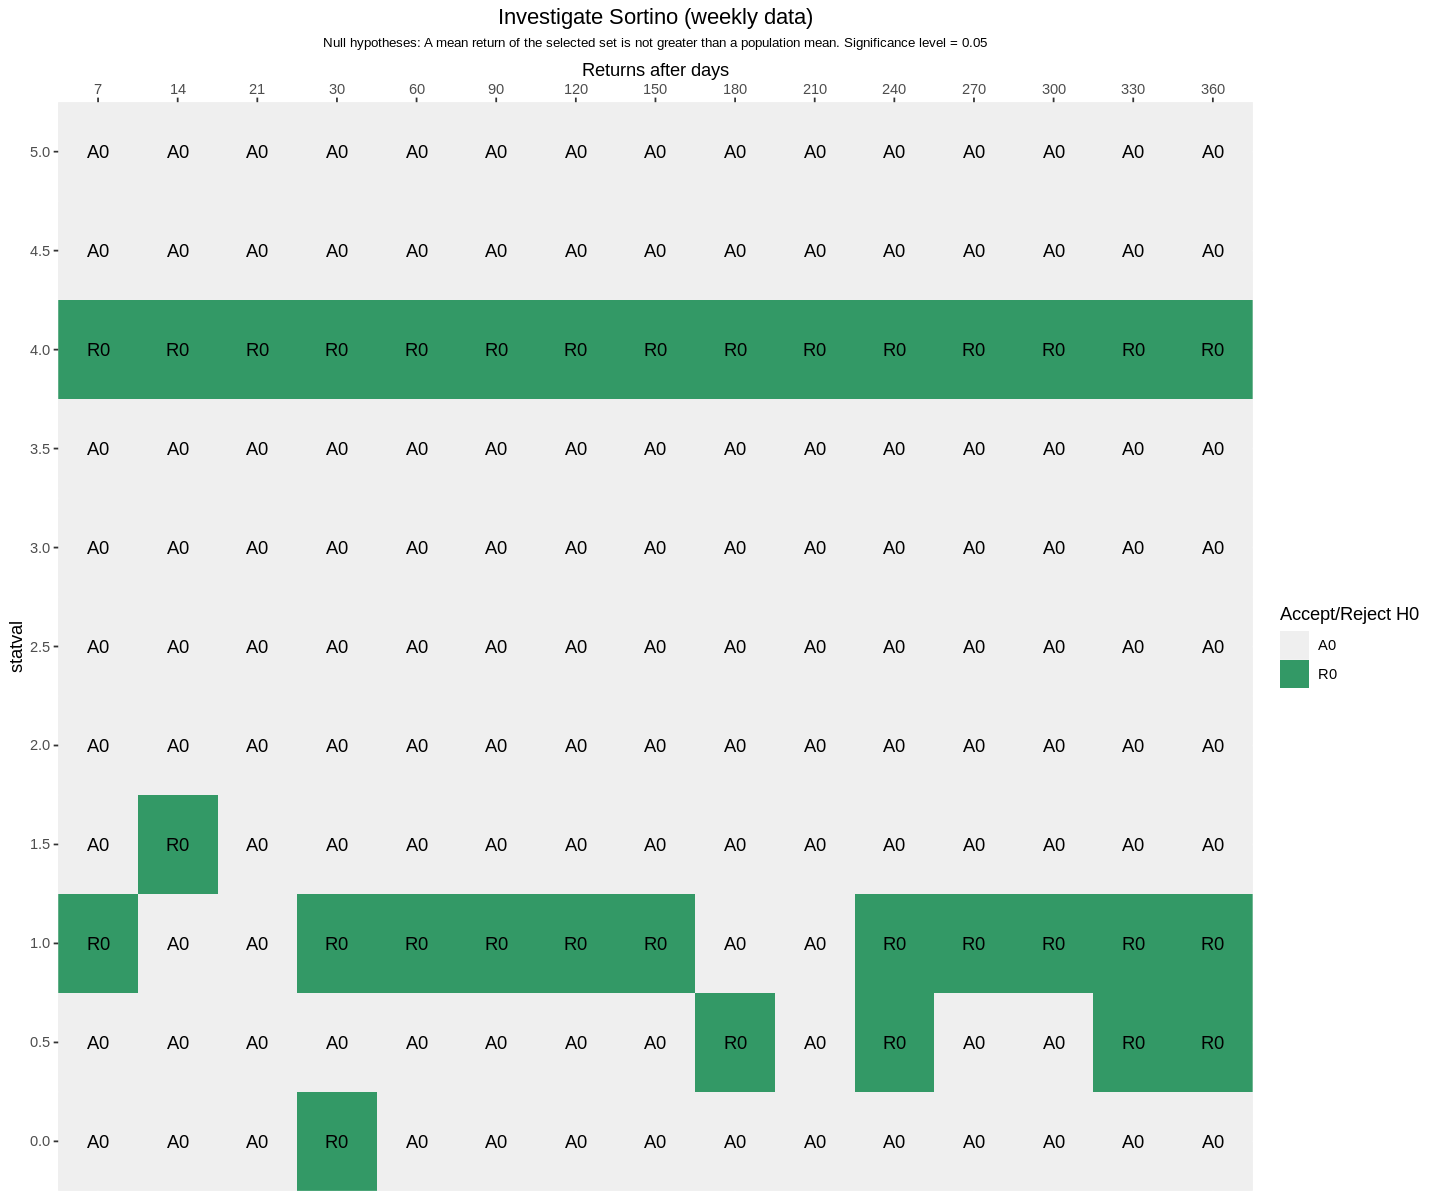

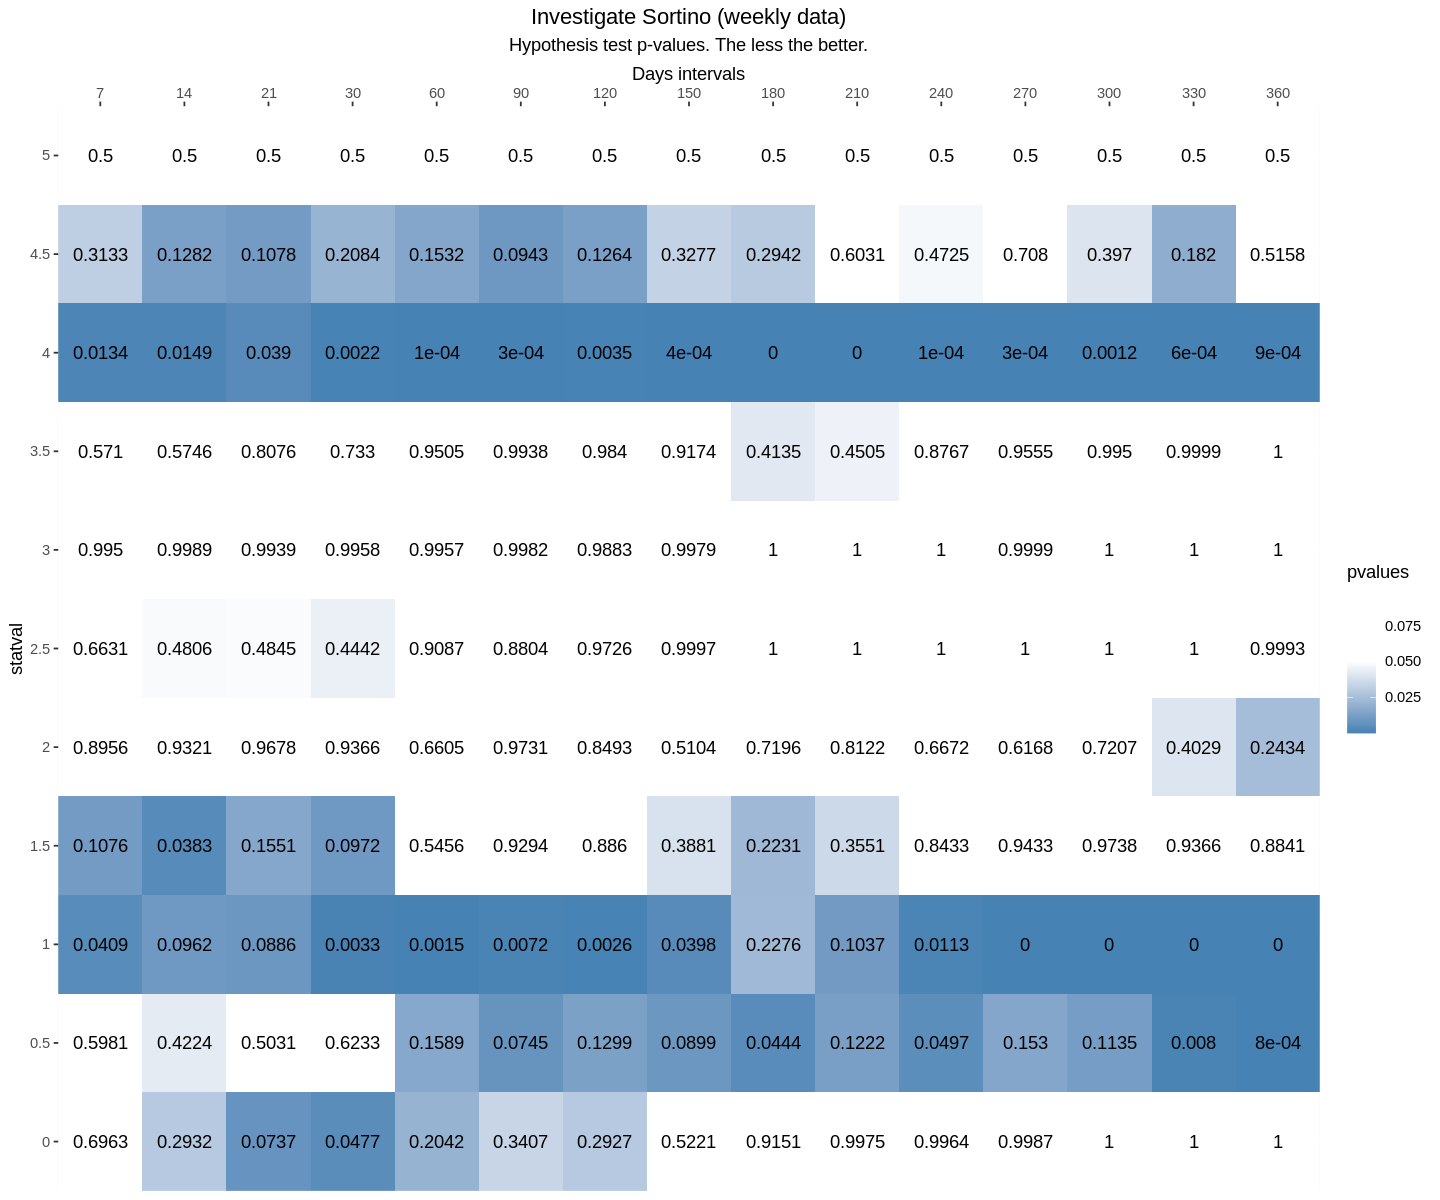

In [5]:
experiment = list(
  name = "Sortino weekly, Age > 90",
  description = "Investigate Sortino (weekly data)",
  sqlText = sql,  # the latest sql above
  attributeName = "statval",
  attributeSteps = seq(from = 0, to = 5, by = 0.5))

result = makeExperiment(experiment)



Hypothesis test of sample standard deviation.

Alternative hypothesis: The sample standard deviation is less than the population SD.


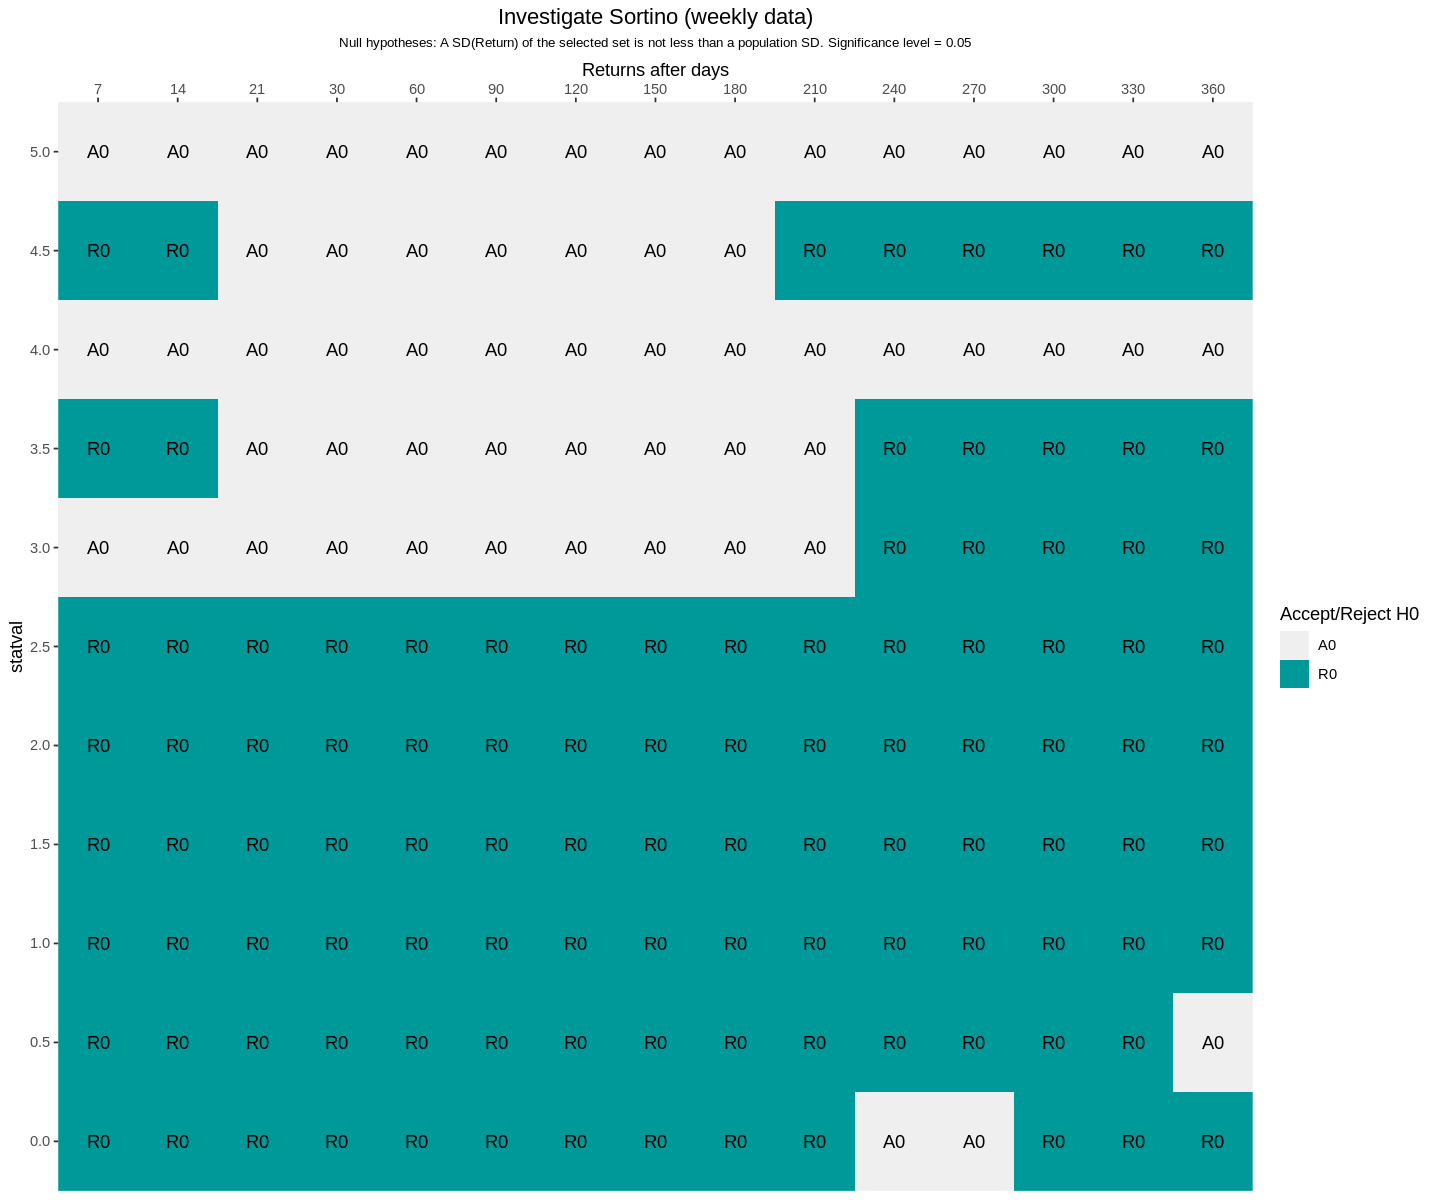

In [6]:
showSDLessHypothesisTest(experiment, result)    

In [7]:
showObservationsCounts(experiment, result)


The following table contains numbers of observations in the used statistics intervals.
A number of observations in the sample is an important part of the hypothesis testing. Be careful if it is low (less than 30).
Collective2 data are calculated in 7-days intervals. It means we have less observations which decreases hypotesis testing reliability. Use daily data tests if available.
Numbers of observations shown in this table are NOT numbers of C2 strategies! Every strategy can have many observations in any statistics interval. That is what is shown here.


Selection,Obs007,Obs014,Obs021,Obs030,Obs060,Obs090,Obs120,Obs150,Obs180,Obs210,Obs240,Obs270,Obs300,Obs330,Obs360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.5 <= statval < 5,992,980,965,941,848,740,681,619,533,480,433,394,354,333,299
4 <= statval < 4.5,1198,1181,1160,1136,1054,941,877,802,727,654,590,519,474,430,387
3.5 <= statval < 4,1663,1637,1609,1565,1432,1278,1137,989,906,851,769,702,626,566,507
3 <= statval < 3.5,2076,2041,2012,1976,1814,1603,1440,1337,1207,1083,979,878,790,745,700
2.5 <= statval < 3,2716,2676,2632,2579,2377,2134,1927,1744,1553,1405,1239,1100,982,880,801
2 <= statval < 2.5,3950,3885,3813,3718,3415,3072,2759,2465,2238,2046,1840,1659,1493,1366,1260
1.5 <= statval < 2,5420,5325,5242,5123,4685,4163,3767,3448,3162,2903,2711,2516,2321,2158,2018
1 <= statval < 1.5,6193,6083,5972,5827,5328,4779,4298,3868,3474,3169,2879,2652,2444,2277,2123
0.5 <= statval < 1,5584,5446,5331,5175,4680,4207,3807,3449,3076,2790,2527,2298,2056,1875,1707



SampleMetricValue minus PopulationMetricValue

This table shows differences between metric values calculated for the whole population and the current sample metric values. (See the chapter 'Population statistics'.)
This is different from our hypothesis test. Our hypothesis test tests an (alternative) hypothesis 'Is a mean of the sample greater than a mean of the population?'
But our metric is 'Mean divided by SD'. So the standard deviation plays a role in it.
Our metric is greater when a numerator is greater and/or denominator is less. It is up to you what you prefer.



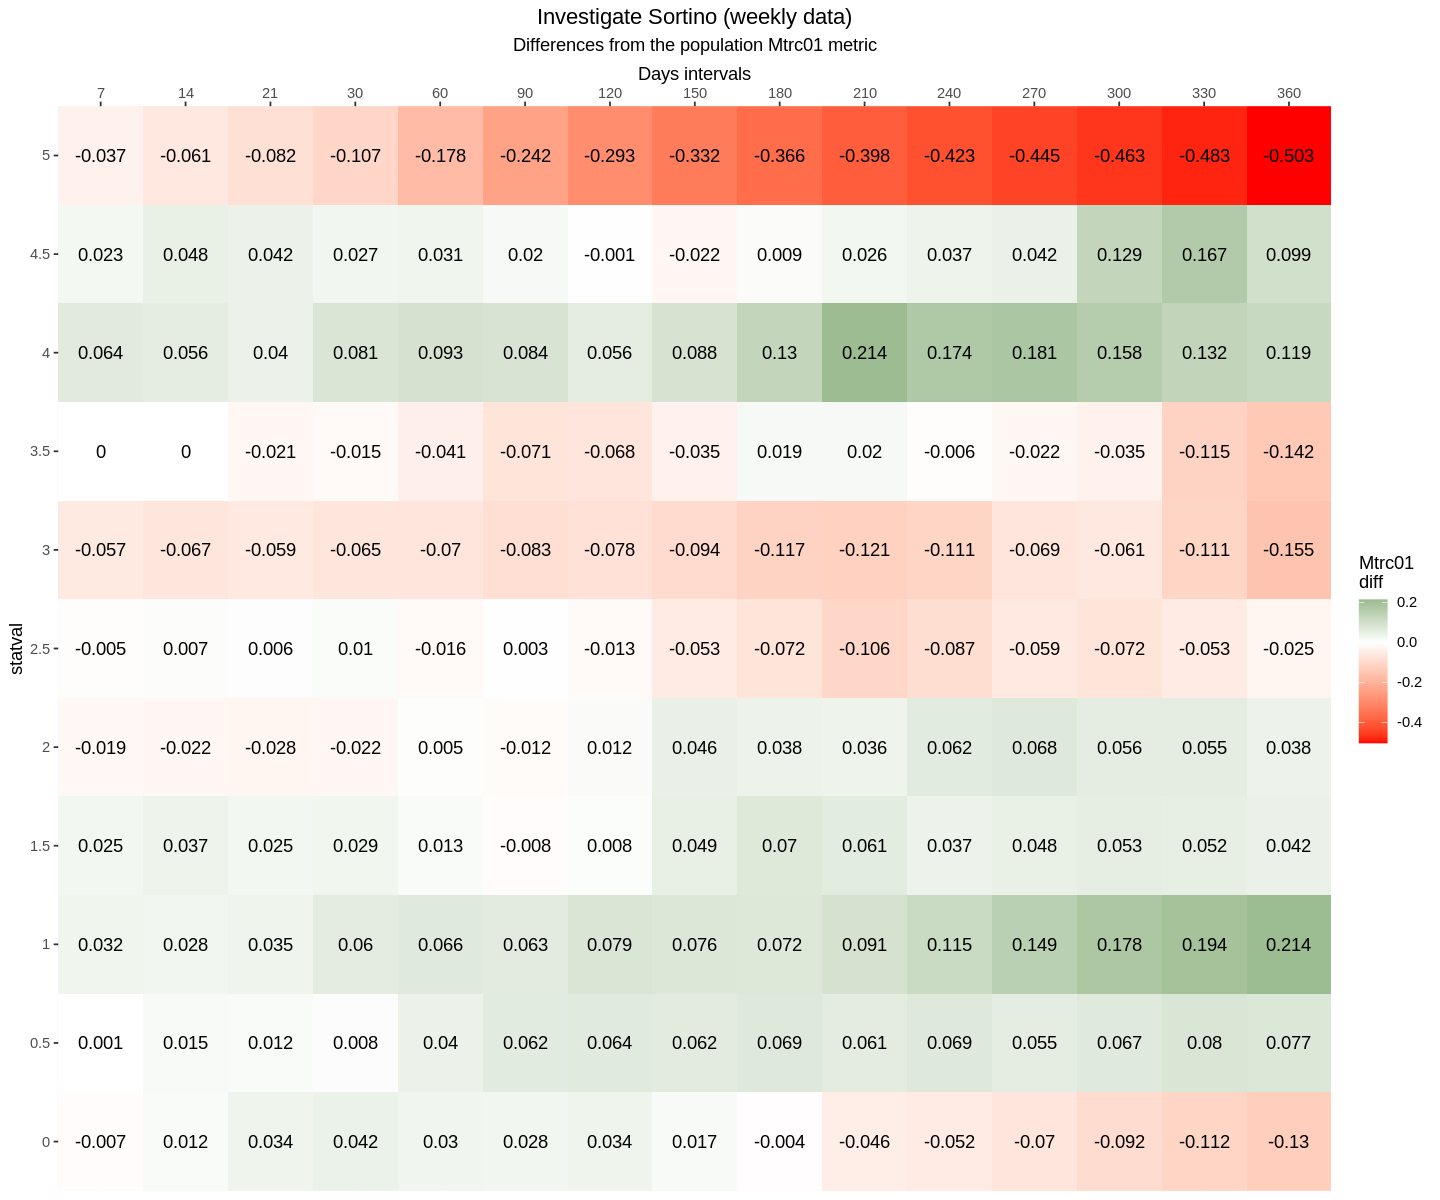

In [8]:
showMetricDifferences(experiment, result)

In [9]:
showSystemsCounts(experiment, result)



Numbers of strategies observed in defined intervals.

Selection,Sys007,Sys014,Sys021,Sys030,Sys060,Sys090,Sys120,Sys150,Sys180,Sys210,Sys240,Sys270,Sys300,Sys330,Sys360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.5 <= statval < 5,298,290,285,275,247,207,188,172,146,130,112,104,90,79,68
4 <= statval < 4.5,330,323,312,299,266,225,209,187,167,142,132,113,105,96,85
3.5 <= statval < 4,397,387,375,360,310,273,244,212,187,176,151,129,110,101,92
3 <= statval < 3.5,438,426,420,404,355,295,261,236,207,191,169,145,125,116,106
2.5 <= statval < 3,491,478,465,449,393,331,289,261,232,212,188,165,141,124,117
2 <= statval < 2.5,563,545,531,514,449,395,347,300,267,235,211,186,161,142,128
1.5 <= statval < 2,624,599,587,566,483,399,345,304,272,230,210,182,164,149,138
1 <= statval < 1.5,627,602,583,559,486,418,368,326,278,239,211,188,173,157,143
0.5 <= statval < 1,614,578,553,526,440,373,333,294,250,223,194,175,152,140,131


### Discussion
 
...................................